This was written after completing the assignment to explain the logic behind what I did. It is my interpretation of the assignment and its associated resources. We are expected to reconfigure the Wavenet neural net architectue to become a predictor rather than a generator. Therefore, we will sample the audio files and at intervals, predicting the immediate audio after that. After training the neural net on this data, we will use this neural network to make predictions in the testing dataset. If the difference between our prediction and the actual prediction differs by more than the error for our model, it will be considered an anomolous sound. Otherwise, it is not. 

# Task 1

In [2]:
# importing libaries
import tensorflow as tf
import tarfile
import gzip
import shutil
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# The following code was copied from the textbook:
# Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow
# I modified the head of the model to make it a predict
# the amplitude of the audio signal that immediately follows
# the 5 amplitudes that precede it (the input)
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.Input(shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
  wavenet_model.add(tf.keras.layers.Conv1D(
  filters=32, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

# Task 2

I downloaded train_normal.tar.gz, test_normal.tar.gz, and test_anomaly.tar.gz, placing them into my working directory. The following are useful functions for processing these files.

In [3]:
# extracts file, placing it into directory with same name
# as file without the file extension
def extract(file):
  with gzip.open(file, 'rb') as inFile:
      with tarfile.open(fileobj=inFile, mode='r') as tar:
          tar.extractall(path=file.split('.')[0])

In [4]:
# recursively deletes a directory
def delete(directory):
  shutil.rmtree(directory)

In [5]:
# returns list of path for all files
# in a directory
def paths(directory):
  result = []
  for fileName in os.listdir(directory):
    result.append(directory + "/" + fileName)
  return result

The following function generates our data from a given file. It will include the amplitude for 5 frames with the 6th frame being the output or label.

In [16]:
# returns list of training data for
# a file
def generate(file_path):
  audio_data, sample_rate = librosa.load(file_path, sr=None)
  audio_data = librosa.util.normalize(audio_data)
  audio_data = audio_data.flatten()
  data = []
  labels = []
  for i in range(0, len(audio_data) - 3, 6):
    data.append(audio_data[i:i+5])
    labels.append(audio_data[i+5])
  return (np.array(data), np.array(labels))

In [7]:
extract("train_normal.tar.gz")
extract("test_normal.tar.gz")
extract("test_anomaly.tar.gz")

In [8]:
train_files = paths("train_normal")
test_files = paths("test_normal")

In [10]:
# quartering the amount of training data
# due to limited RAM capabilities
train_files = train_files[:len(train_files)//4]
test_files = test_files[:len(test_files)//4]

In [113]:
# generates training data/labels
x_train = []
y_train = []
for f in train_files:
  res = generate(f)
  x_train.append(res[0])
  y_train.append(res[1])
temp = []
for x in x_train:
    for y in x:
        temp.append(y)
x_train = np.array(temp)
y_train = np.array(y_train).ravel()

In [114]:
# generates testing data/labels
x_test = []
y_test = []
for f in test_files:
  res = generate(f)
  x_test.append(res[0])
  y_test.append(res[1])
temp = []
for x in x_test:
    for y in x:
        temp.append(y)
x_test = np.array(temp)
y_test = np.array(y_test).ravel()

# Task 3

Here I compiled the model and trained it using various different batch sizes that can be clearly be seen by the reassignment of the batch size variable prior to training.

In [115]:
wavenet_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [116]:
train_extra = len(x_train)%160
test_extra = len(x_test)%160

In [118]:
resized_x_train = x_train[:-train_extra]
resized_y_train = y_train[:-train_extra]
resized_x_test = x_test[:-test_extra]
resized_y_test = y_test[:-test_extra]

In [121]:
batch_size = 32
resized_x_train = np.reshape(resized_x_train, (-1, batch_size, 5))
resized_x_test = np.reshape(resized_x_test, (-1, batch_size, 5))
resized_y_train = np.reshape(resized_y_train, (-1, batch_size, 1))
resized_y_test = np.reshape(resized_y_test, (-1, batch_size, 1))

In [124]:
wavenet_model.fit(resized_x_train, resized_y_train, batch_size=batch_size, epochs=10, validation_data=(resized_x_test, resized_y_test), verbose=1)

Epoch 1/10
3581/3581 [==============================] - 226s 63ms/step - loss: 0.0020 - mae: 0.0312 - val_loss: 0.0020 - val_mae: 0.0312
Epoch 2/10
3581/3581 [==============================] - 216s 60ms/step - loss: 0.0019 - mae: 0.0311 - val_loss: 0.0019 - val_mae: 0.0311
Epoch 3/10
3581/3581 [==============================] - 217s 61ms/step - loss: 0.0019 - mae: 0.0310 - val_loss: 0.0019 - val_mae: 0.0310
Epoch 4/10
3581/3581 [==============================] - 215s 60ms/step - loss: 0.0019 - mae: 0.0309 - val_loss: 0.0019 - val_mae: 0.0307
Epoch 5/10
3581/3581 [==============================] - 216s 60ms/step - loss: 0.0019 - mae: 0.0308 - val_loss: 0.0019 - val_mae: 0.0308
Epoch 6/10
3581/3581 [==============================] - 214s 60ms/step - loss: 0.0019 - mae: 0.0307 - val_loss: 0.0019 - val_mae: 0.0309
Epoch 7/10
3581/3581 [==============================] - 212s 59ms/step - loss: 0.0019 - mae: 0.0306 - val_loss: 0.0019 - val_mae: 0.0307
Epoch 8/10
3581/3581 [===================

Text(0.5, 1.0, 'Epochs vs. Loss For Batch Size 32')

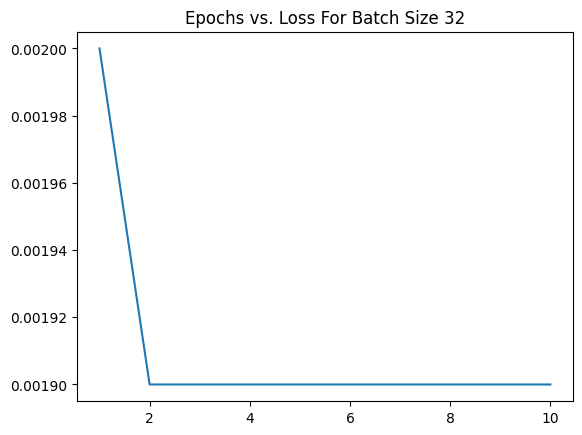

In [129]:
# numbers are from the training shown above
epochs = list(range(1,11))
losses = [0.0020, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019]
plt.plot(epochs, losses)
plt.title("Epochs vs. Loss For Batch Size 32")

In [130]:
batch_size = 64
resized_x_train = np.reshape(resized_x_train, (-1, batch_size, 5))
resized_x_test = np.reshape(resized_x_test, (-1, batch_size, 5))
resized_y_train = np.reshape(resized_y_train, (-1, batch_size, 1))
resized_y_test = np.reshape(resized_y_test, (-1, batch_size, 1))

In [131]:
wavenet_model.fit(resized_x_train, resized_y_train, batch_size=batch_size, epochs=10, validation_data=(resized_x_test, resized_y_test), verbose=1)

Epoch 1/10
896/896 [==============================] - 168s 186ms/step - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0019 - val_mae: 0.0303
Epoch 2/10
896/896 [==============================] - 154s 172ms/step - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0019 - val_mae: 0.0304
Epoch 3/10
896/896 [==============================] - 154s 172ms/step - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0018 - val_mae: 0.0302
Epoch 4/10
896/896 [==============================] - 154s 172ms/step - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0018 - val_mae: 0.0303
Epoch 5/10
896/896 [==============================] - 154s 172ms/step - loss: 0.0018 - mae: 0.0300 - val_loss: 0.0018 - val_mae: 0.0302
Epoch 6/10
896/896 [==============================] - 153s 171ms/step - loss: 0.0018 - mae: 0.0300 - val_loss: 0.0019 - val_mae: 0.0305
Epoch 7/10
896/896 [==============================] - 152s 170ms/step - loss: 0.0018 - mae: 0.0300 - val_loss: 0.0018 - val_mae: 0.0302
Epoch 8/10
896/896 [============================

Text(0.5, 1.0, 'Epochs vs. Loss For Batch Size 64')

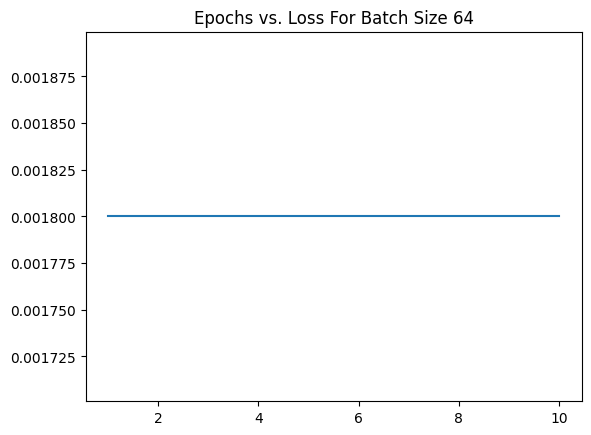

In [3]:
# numbers are from the training shown above
epochs = list(range(1,11))
losses = [0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018]
plt.plot(epochs, losses)
plt.title("Epochs vs. Loss For Batch Size 64")

In [136]:
# Now, I will calculate the F1 score by using the model
# to make predictions on the testing dataset
predictions = wavenet_model.predict(resized_x_test)

7878/7878 [==============================] - 89s 11ms/step


In [142]:
# calculating mean squared error for
# each prediction
mses = []
for i in range(len(predictions)):
    total = 0
    for j in range(len(predictions[i])):
        total = (resized_y_test[i][j] - predictions[i][j])
    mses.append(total/batch_size)

In [232]:
# if mse is greater than loss of model,
# audio classified as anomolous
false_positives = 0
for mse in mses:
    if mse > 0.0018:
        false_positives += 1

In [233]:
true_negatives = len(mses) - false_positives

In [219]:
# calculating mean squared error for each prediction
# on anomolous test data
# this involves repeating steps I've done previously
# on the normal training and testing data
# (see above)
a_test_files = paths("test_anomaly")
a_test_files = test_files[:len(a_test_files)//4]
a_x_test = []
a_y_test = []
for f in a_test_files:
  res = generate(f)
  a_x_test.append(res[0])
  a_y_test.append(res[1])

In [220]:
temp = []
for x in a_x_test:
    for y in x:
        temp.append(y)
a_x_test = np.array(temp)
a_y_test = np.array(a_y_test).ravel()

In [224]:
a_test_extra = len(a_x_test)%320
resized_a_x_test = a_x_test[:-a_test_extra]
resized_a_y_test = a_y_test[:-a_test_extra]

In [225]:
resized_a_x_test = np.reshape(resized_a_x_test, (-1, batch_size, 5))
resized_a_y_test = np.reshape(resized_a_y_test, (-1, batch_size, 1))

In [226]:
a_predictions = wavenet_model.predict(resized_a_x_test)

3782/3782 [==============================] - 76s 20ms/step


In [227]:
a_mses = []
for i in range(len(a_predictions)):
    total = 0
    for j in range(len(a_predictions[i])):
        total = (resized_a_y_test[i][j] - a_predictions[i][j])
    a_mses.append(total/batch_size)

In [234]:
# if mse is greater than loss of model,
# audio classified as anomolous
true_positives = 0
for mse in mses:
    if mse > 0.0018:
        true_positives += 1

In [235]:
false_negatives = len(a_mses) - true_positives

In [237]:
f1 = true_positives / (true_positives + 0.5 * (false_positives + false_negatives))

In [240]:
print("F1 Score: " + str(f1))

F1 Score: 0.03644153506781024
